In [3]:
import tensorflow as tf
import json
import os
import matplotlib.pyplot as plt

In [4]:
# Function to load COCO dataset annotations
def load_coco_annotations(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    return annotations

In [5]:
# Function to preprocess images and annotations
def preprocess_image_and_annotations(image_path, annotations, categories):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    # Convert annotations to a single label (e.g., majority class for simplicity)
    if annotations:
        label = categories[annotations[0]['category_id']]
    else:
        label = 0  # Assuming 0 is a valid class ID
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    return image, label

In [6]:
# Function to load dataset
def load_dataset(dataset_dir, split):
    split_dir = os.path.join(dataset_dir, split)
    annotations_file = os.path.join(split_dir, '_annotations.coco.json')
    annotations = load_coco_annotations(annotations_file)
    categories = {category['id']: i for i, category in enumerate(annotations['categories'])}
    category_names = {i: category['name'] for i, category in enumerate(annotations['categories'])}
    images = {image['id']: image for image in annotations['images']}
    image_paths = [os.path.join(split_dir, image['file_name']) for image in images.values()]
    image_annotations = {image['file_name']: [] for image in images.values()}
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        file_name = images[image_id]['file_name']
        image_annotations[file_name].append(annotation)
    return image_paths, image_annotations, categories, category_names

In [7]:
# Path to the dataset directory
dataset_dir = 'dataset'

In [8]:
# Load train, valid, and test datasets
train_image_paths, train_annotations, categories, category_names = load_dataset(dataset_dir, 'train')
valid_image_paths, valid_annotations, _, _ = load_dataset(dataset_dir, 'valid')
test_image_paths, test_annotations, _, _ = load_dataset(dataset_dir, 'test')

In [9]:
# Create TensorFlow datasets
def create_tf_dataset(image_paths, annotations, categories):
    def generator():
        for image_path in image_paths:
            image_name = os.path.basename(image_path)
            image_data = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image_data, channels=3)
            image = tf.image.resize(image, [128, 128])
            annotation = annotations.get(image_name, [])
            if annotation:
                label = categories[annotation[0]['category_id']]
            else:
                label = 0  # Assuming 0 is a valid class ID
            yield image, label
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)))
    return dataset

In [10]:
train_dataset = create_tf_dataset(train_image_paths, train_annotations, categories)
valid_dataset = create_tf_dataset(valid_image_paths, valid_annotations, categories)
test_dataset = create_tf_dataset(test_image_paths, test_annotations, categories)

In [11]:
# Batch and shuffle the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)
valid_dataset = valid_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [12]:
# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(categories), activation='softmax')  # Adjust based on number of classes
])

c:\Users\ferra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
     51/Unknown 40s 368ms/step - accuracy: 0.3250 - loss: 43.4155

c:\Users\ferra\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 471ms/step - accuracy: 0.3263 - loss: 42.9001 - val_accuracy: 0.4400 - val_loss: 1.2427
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.4922 - loss: 1.1901 - val_accuracy: 0.5167 - val_loss: 1.1481
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.5209 - loss: 1.1114 - val_accuracy: 0.5267 - val_loss: 1.1838
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.5473 - loss: 1.0648 - val_accuracy: 0.4867 - val_loss: 1.1701
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.5488 - loss: 1.0876 - val_accuracy: 0.4700 - val_loss: 1.1561
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.5503 - loss: 1.0731 - val_accuracy: 0.4867 - val_loss: 1.1424
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.5649 - loss: 1.0023 - val_accuracy: 0.4667 - val_loss: 1.1895
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.5728 - loss: 1.0055 - val_accuracy: 0.49

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.4152 - loss: 1.4164
Test accuracy: 0.4000000059604645


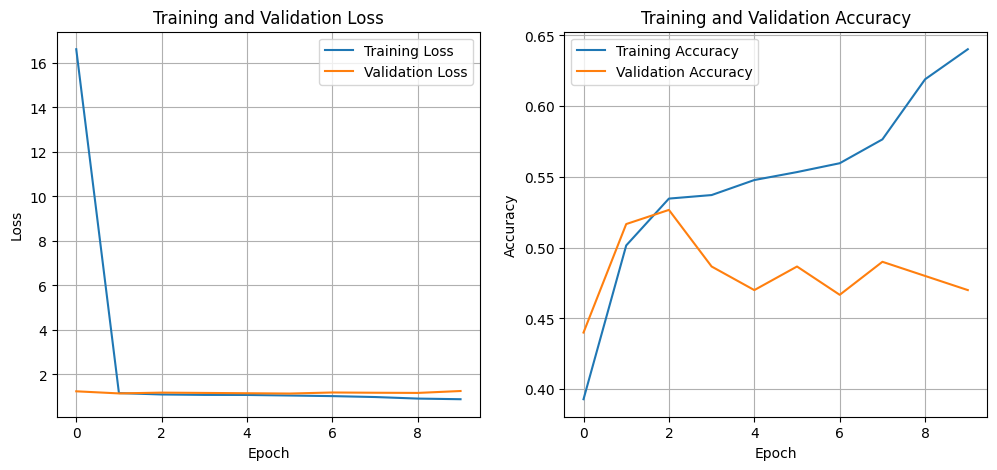

In [16]:
# Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_training_history(history)

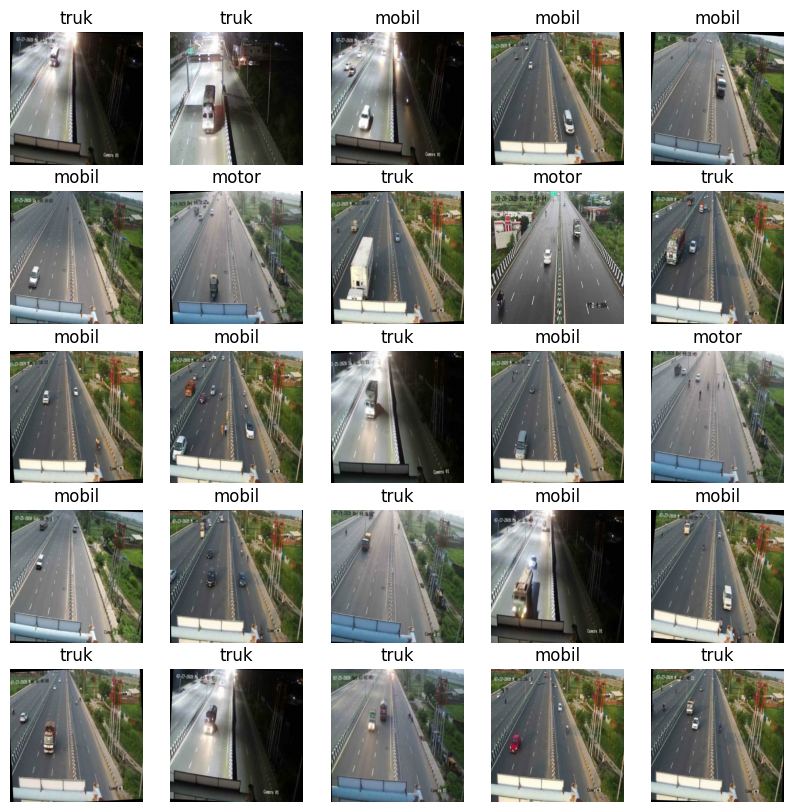

In [17]:
# Visualization of the dataset
def plot_images_with_labels(image_paths, annotations, categories, category_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        image_path = image_paths[i]
        image_name = os.path.basename(image_path)
        annotation = annotations.get(image_name, [])
        if annotation:
            label = categories[annotation[0]['category_id']]
            label_name = category_names[label]
        else:
            label_name = "Unknown"
        
        image_data = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(label_name)
        plt.axis("off")
    plt.show()

# Plot some images with labels from the training dataset
plot_images_with_labels(train_image_paths, train_annotations, categories, category_names)